### ЛР. Часть II: Large scale text analysis with deep learning (4 points)


**Для успешной сдачи этой части ЛР - нужно получить MAE < 0.11**

За датасет спасибо [Oleg Vasilev](https://github.com/Omrigan/)

Мы будем предсказывать ЗП по резюме. Начнем с семинара, закончим ЛР.

**Для успешной сдачи этой части ЛР - нужно получить MAE < 0.11**

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

### Начало

Сначала разумеется нужно скачать датасет с яндекс диска.

Данные сделаны на основе Kaggle соревнования - https://www.kaggle.com/c/job-salary-prediction/data


In [5]:
#import requests
#from urllib.parse import urlencode

#base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
#public_key = 'https://disk.yandex.ru/d/DoFaLhNST81AgA'

# Получаем загрузочную ссылку
#final_url = base_url + urlencode(dict(public_key=public_key))
#response = requests.get(final_url)
#download_url = response.json()['href']

# Загружаем файл и сохраняем его
#download_response = requests.get(download_url)

In [6]:
#with open('./Train_rev1.csv', 'wb') as f:
#    f.write(download_response.content)

In [7]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [8]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


Одна из проблем с предсказанием зарплат заключается в том, что они распределены необычным образом (хотя кто слушал лекции по классик мл было все идеально): существует много людей, которые получают стандартные зарплаты, и немного тех, кто зарабатывает огромные суммы. Распределение имеет "жирный хвост" на правой стороне, что неудобно для минимизации MSE.

Существует несколько методов для решения этой проблемы: использование другой функции потерь (MSLE), предсказание логарифма целевой переменной вместо исходного значения (LOG1P), или даже замена целевых значений их процентилями среди всех зарплат в обучающем наборе (ДИСКРЕТИЗАЦИЯ????).

Для простоты и вашего интереса буду юзать log1p

_Подробнее можно прочитать [в официальном описании](https://www.kaggle.com/c/job-salary-prediction#description)._

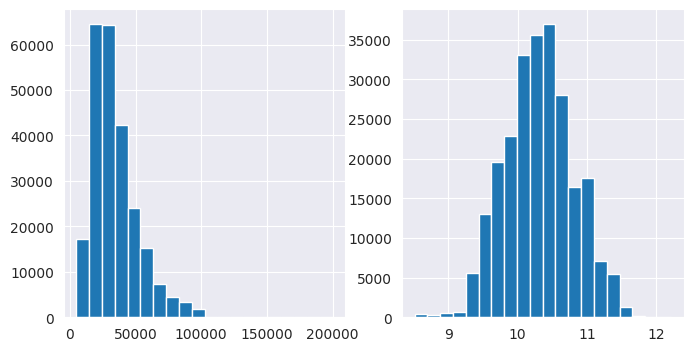

In [9]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Наша задача — предсказать одно число, __Log1pSalary__.

Для этого наша модель может использовать несколько признаков:
* Текстовые данные: __`Title`__ и  __`FullDescription`__
* Категориальные данные: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__ и __`ContractTime`__.

In [10]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
30880,68067787,Sales Negotiator Excellent OTE Start Now,A leading London Estate agent is currently rec...,London South East,South East London,NaN,permanent,Bond Recruitment,Trade & Construction Jobs,"18000-32000 Per Annum Uncapped OTE, Company Ca...",25000,totaljobs.com,10.126671
197012,71830411,Front Office Risk Analyst Derivatives,Overview This is a fantastic opportunity for a...,London,London,NaN,NaN,Rees Draper Wright,Accounting & Finance Jobs,"50,000 to 70,000",60000,eFinancialCareers,11.002116
73067,68983015,"LOCUM ADVANCE NURSE PRACTITIONERS REQUIRED, ON...",Type: Locum Location: Grimsby Hours: Flexible ...,Lincolnshire,Lincolnshire,full_time,contract,Merco,Healthcare & Nursing Jobs,37.00 - 40.00 GBP Hourly,73920,jobs.newstatesman.com,11.210752


### Препроцессинг

Как и на прошлой неделе, NLP начинается с токенизации: разбиения исходного текста на последовательности токенов (слов, знаков пунктуации и т.д.).

__Ваша задача__ — привести к нижнему регистру и токенизировать все тексты в столбцах `Title` и `FullDescription`. Сохраните токенизированные данные в виде строки с токенами, разделенными __пробелами__, для повышения производительности.


In [11]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [12]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

In [13]:
data['FullDescription'] = data['FullDescription'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x))).lower())
data['Title'] = data['Title'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x))).lower())

Теперь мы можем предположить, что наш текст - это список лексем, разделенных пробелами:

In [14]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Не все слова одинаково полезны. Некоторые из них - опечатки или редкие слова, которые встречаются всего несколько раз.

Давайте подсчитаем, сколько раз каждое слово встречается в данных, чтобы составить «белый список» известных слов.

In [15]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for text in data['FullDescription'].values:
    for token in text.split():
        token_counts[token] += 1

for text in data['Title'].values:
    for token in text.split():
        token_counts[token] += 1

In [16]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


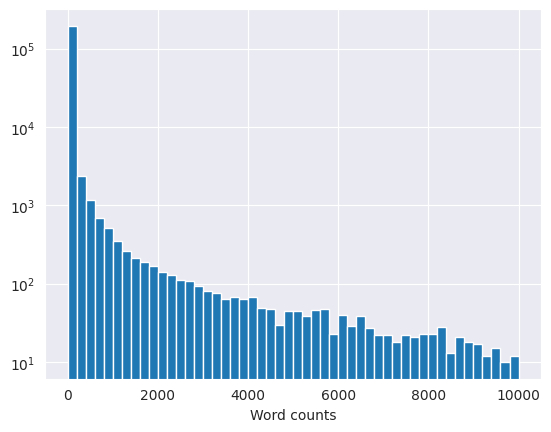

In [17]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Задание 1.1__ Получите список всех токенов, которые встречаются не менее 10 раз.

In [18]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(token for token, count in token_counts.items() if count >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [19]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Задача 1.2__ Постройте обратный индекс токена: словарь от токена(string) до его индекса в `tokens` (int)

In [20]:
token_to_id = {token: index for index, token in enumerate(tokens)}

In [21]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [22]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [23]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Теперь давайте закодируем имеющиеся у нас категориальные данные.

Для простоты мы будем использовать кодировку one-hot. Но естесна тот же tfidf даст качество выше

In [24]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### DL Part (Хелло Д.В. Сош.)

После того как мы научились токенизировать данные, давайте подкрадемся к машинному обучению.

Для простоты - обычный train test split

In [25]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


ЕСТЬ ВОПРОСИК!!!

In [26]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [27]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]], device='cuda:0'),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Архитектура

Наша базовая модель состоит из трех частей:
* Title Encoder
* Description encoder
* Categorical features encoder

Затем мы объединим все 3 реза в одну сетку, которая предсказывает зарплату.



<img src="https://i.imgur.com/yP8CgVK.png" alt="Image" width="400"/>

In [29]:
import torch
from torch import nn


class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]


class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), embedding_dim=128, num_filters=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, embedding_dim, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters,
                               kernel_size=3, padding=1)

        self.pool = GlobalMaxPooling()
        self.relu = nn.ReLU()
        self.linear = nn.Linear(num_filters, num_filters)

    def forward(self, batch):
        title_ix = batch["Title"].clone().detach()
        x = self.emb(title_ix)
        x = torch.transpose(x, 1, 2)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

In [30]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), embedding_dim=128, num_filters=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, embedding_dim, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters,
                               kernel_size=3, padding=1)
        self.pool = GlobalMaxPooling()
        self.relu = nn.ReLU()
        self.linear = nn.Linear(num_filters, num_filters)

    def forward(self, batch):
        x = self.emb(batch['FullDescription'])
        x = torch.transpose(x, 1, 2)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

In [31]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = TitleEncoder(n_tokens=n_tokens, num_filters=64)
        self.desc_encoder = DescriptionEncoder(n_tokens=n_tokens, num_filters=64)

        self.layers = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )

        self.out = nn.Linear(160, 1)

    def forward(self, batch):
        title = self.title_encoder(batch)
        desc = self.desc_encoder(batch)

        tensor = batch['Categorical'].clone().detach().requires_grad_(True)
        cat = self.layers(tensor)

        join = torch.cat([title, desc, cat], dim=1)
        out = self.out(join)
        return out[:, 0]

In [32]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Обучение и оценка

Как обычно, мы будем кормить нашего монстра случайными минибатчами данных.

В процессе обучения мы хотим отслеживать не только функцию потерь, которая вычисляется в логарифмическом пространстве, но и фактическую ошибку, измеряемую в долларах.

In [33]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

## Обучение модели (И ОСНОВНЫЕ ИДЕИ)

Теперь мы можем подогнать нашу модель под обычные минибатчи. Забавность в том, что мы обучаемся на бесконечном потоке минибатчей, создаваемых функцией `iterate_minibatches`. Экономия памяти, ю ноу?


Главная задача - использовать некоторые трюки, которым мы научились и проанализировать, можете ли вы улучшить __validation MAE__. Попробуйте __как минимум 3 варианта__, напишите репорт и добейтесь MAE < 0.11. Больше идей (и реализаций) = больше бонусных баллов.

__Только все делаем нормально:__ постройте кривые обучения в MAE/epoch, сравните результаты обучения / метрик моделей друг с другом

Вы можете использовать как __pytorch__ или __tensorflow__, так и любой другой фреймворк (например, чистый __keras__). Не стесняйтесь адаптировать код семинара под свои нужды.

## Рекомендуемые варианты

#### A) Архитектура CNN

Все известные трюки, связанные с полносвязными и сверточными нейронными сетями, применимы и здесь:
* Dropout. Без комментариев.
* Batch Norm. В этот раз используем `nn.BatchNorm*`/`L.BatchNormalization`.
* Параллельные сверточные слои. Идея заключается в том, чтобы применить несколько `nn.Conv1d` к одним и тем же эмбеддингам и объединить выходные каналы.
* Больше слоев, больше нейронов, как обычно...

#### B) Эксперименты с пулингом

Существует несколько способов пулинга:
* Max pooling
* Mean pooling
* Softmax pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } } $$

* Attentive pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

где $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$,
а $NN_{attn}$ — это полносвязный слой.

Оптимальные результаты обычно достигаются путем объединения нескольких различных видов пулинга, включая несколько Attentive pooling с разными $NN_{attn}$.


#### C) Работа со словами

Не всегда разумно обучать эмбеддинги с нуля. Вот несколько приемов:

* Используйте предобученные эмбеддинги из `gensim.downloader.load`. См. последнюю лекцию.
* Начните с предобученных эмбеддингов, а затем дообучайте их с помощью градиентного спуска. Вы можете загрузить предобученные эмбеддинги, например, [отсюда](http://nlp.stanford.edu/data/glove.6B.zip)
* Используйте одну и ту же матрицу эмбеддингов для векторизаторов заголовков и описаний.

#### D) Использование рекуррентных сетей

Мы уже узнали, что рекуррентные сети могут быть полезны в моделировании последовательностей. Оказывается, они могут быть полезны и для классификации, с некоторыми хитростями...

* Как и в случае со сверточными слоями, выход LSTM следует свести к вектору фиксированного размера с помощью одного из пулингов.
* Поскольку вы заранее знаете весь текст, используйте двунаправленную RNN:
  * Запустите одну LSTM слева направо.
  * Запустите другую параллельно справа налево.
  * Объедините их выходные последовательности по оси единиц (dim=-1).

* Возможно, хорошей идеей будет смешать сверточные и рекуррентные слои для заголовков и описаний.

#### E) Серьезная оптимизация

* Не обязательно тренировать модель 100 эпох. Используйте раннюю остановку (early stopping). Если вы никогда этого не делали, взгляните на [callback ранней остановки в Keras](https://keras.io/callbacks/#earlystopping) или в [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * В двух словах, тренируйте модель до тех пор, пока валидация не начнет ухудшаться.
  * Сохраняйте лучший по валидации снимок модели через `model.save(file_name)`.

Удачи! И да пребудет с вами сила!

In [34]:
BATCH_SIZE = 128
EPOCHS = 50

In [35]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            batch_target = batch[TARGET_COLUMN]
            squared_error += torch.sum(torch.square(batch_pred - batch_target))
            abs_error += torch.sum(torch.abs(batch_pred - batch_target))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [36]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=2,
                                                          threshold=0.005,
                                                          threshold_mode='rel',
                                                          cooldown=0, min_lr=0, eps=1e-8)

In [37]:
df_results = pd.DataFrame(columns=['mse', 'mae', 'lr'])

In [38]:
from tqdm.auto import tqdm

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
                         total=len(data_train) // BATCH_SIZE):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    mse, mae = print_metrics(model, data_val, device=device)
    lr_scheduler.step(mae)
    lr = lr_scheduler._last_lr[0]
    df_results.loc[epoch] = {'mse': mse, 'mae': mae, 'lr': lr}
    if mae <= 0.11: break

epoch: 0


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.30298
Mean absolute error: 0.41649
epoch: 1


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.15748
Mean absolute error: 0.29951
epoch: 2


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.10832
Mean absolute error: 0.24757
epoch: 3


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.08799
Mean absolute error: 0.22157
epoch: 4


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.07830
Mean absolute error: 0.20850
epoch: 5


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.07312
Mean absolute error: 0.20094
epoch: 6


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.07188
Mean absolute error: 0.19865
epoch: 7


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06795
Mean absolute error: 0.19362
epoch: 8


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06702
Mean absolute error: 0.19252
epoch: 9


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06555
Mean absolute error: 0.18978
epoch: 10


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06491
Mean absolute error: 0.18861
epoch: 11


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06628
Mean absolute error: 0.19196
epoch: 12


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06337
Mean absolute error: 0.18618
epoch: 13


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06345
Mean absolute error: 0.18627
epoch: 14


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06318
Mean absolute error: 0.18569
epoch: 15


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06314
Mean absolute error: 0.18607
epoch: 16


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06193
Mean absolute error: 0.18360
epoch: 17


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06176
Mean absolute error: 0.18314
epoch: 18


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06174
Mean absolute error: 0.18311
epoch: 19


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06183
Mean absolute error: 0.18329
epoch: 20


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06180
Mean absolute error: 0.18318
epoch: 21


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18323
epoch: 22


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18321
epoch: 23


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 24


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18321
epoch: 25


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06182
Mean absolute error: 0.18321
epoch: 26


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18321
epoch: 27


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18321
epoch: 28


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 29


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 30


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 31


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 32


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 33


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 34


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 35


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 36


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 37


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 38


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 39


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 40


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 41


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 42


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 43


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 44


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 45


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 46


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 47


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 48


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322
epoch: 49


  0%|          | 0/1529 [00:00<?, ?it/s]

 results:
Mean square error: 0.06181
Mean absolute error: 0.18322


In [39]:
df_results.describe()

,mse,mae,lr
count,50.000000,50.000000,5.000000e+01
mean,0.071331,0.194471,3.087100e-05
std,0.036770,0.037467,4.579281e-05
min,0.061743,0.183114,1.000000e-08
25%,0.061813,0.183217,1.000000e-08
50%,0.061814,0.183219,5.500000e-08
75%,0.063431,0.186246,1.000000e-04
max,0.302977,0.416491,1.000000e-04


Минимальная полученная величина MAE - 0.1831

График изменения MAE & MSE по эпохам обучения:

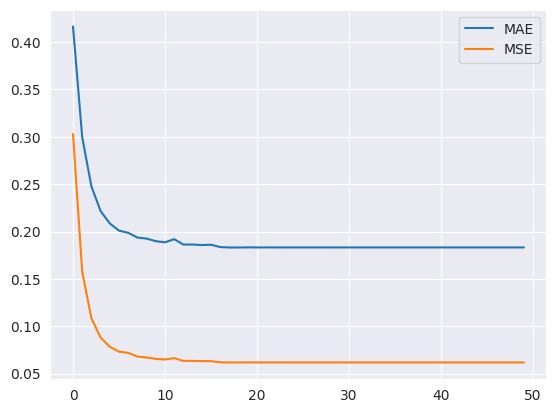

In [40]:
plt.plot(df_results['mae'])
plt.plot(df_results['mse'])
plt.legend(['MAE', 'MSE'])
plt.show()

Изменение скорости обучения по эпохам:

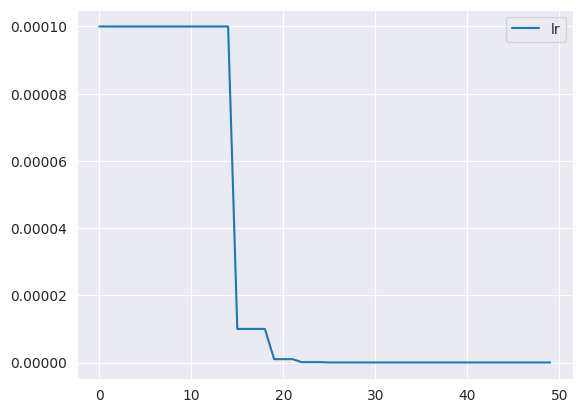

In [41]:
plt.plot(df_results['lr'])
plt.legend(['lr'])
plt.show()

### Бонусная часть: объяснение предсказаний модели

Обычно полезно понять, как работает модель, прежде чем позволить ей принимать решения в проде.

Для линейных моделей это просто: достаточно посмотреть, какие слова приобрели положительные или отрицательные веса. Однако гораздо сложнее с нейронными сетями, которые учатся сложным нелинейным зависимостям.

Однако есть несколько способов заглянуть внутрь «черного ящика»:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Сегодня мы попробуем первый метод, просто потому что он самый простой.

In [42]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [43]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [44]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [45]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 49096
Salary (gbp): tensor([26592.4512])


english teacher uk wide

please note : our client currently has a number of people working for them on an ` as and when ` basis , which fits in well with their current circumstances . purpose of the job within the framework of your expert area ( english ), to deliver engaging and inspirational programmes leading to defined outcomes for young learners in accordance with our client ` s company values and which meet prescribed internal and external standards , in accordance with the detailed specification agreed with the particular client . skills and experience a relevant degree and pgce in english excellent teaching ability and the commitment to gain results with d / c borderline pupils ability to engage with and inspire young learners by using appropriate training techniques and interpersonal skills desirable experience of marking exam papers reporting to : course lead trainer responsible for : training of young people key tasks deliver the agreed programme in accordance with the lesson plan ability to mark official exam papers quickly and accurately person specification smart in appearance organised enthusiastic passionate dynamic can build positive relationships with both staff and students flexible excellent timekeeper you must hold a valid crb and driving license for this position . nb : this description gives a broad explanation of the duties of this post , however these may vary over time